---
title: Spatial Operators
suptitle: How can we construct our custom spatial operators?
short_title: Different Spatial Operators
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [2]:
import autoroot

import finitediffx as fdx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

$$
\vec{\mathbf{x}}= 
\begin{bmatrix}
x \\ y
\end{bmatrix}
$$

$$
\boldsymbol{u}(x,y) = \sin(x)\cos(y)
$$

In [3]:
# dydx of a 2D array
x, y = [jnp.linspace(0, 1, 100)] * 2
dx, dy = x[1] - x[0], y[1] - y[0]
X, Y = jnp.meshgrid(x, y, indexing="ij")
F = jnp.sin(X) * jnp.cos(Y)

### Analytical

$$
\partial_x \boldsymbol{f}(x,y) = \cos(y)\cos(x)
$$

$$
\partial_x \boldsymbol{f}(x,y) = -\sin(x)\cos(y)
$$

In [4]:
dFdX_analytical = jnp.cos(Y) * jnp.cos(X)
dFdY_analytical = -jnp.sin(X) * jnp.sin(Y)

### Functional API

In [5]:
accuracy = 1
derivative = 1
method = "central"
dFdX_func_api = fdx.difference(
    array=F, axis=0, step_size=dx, accuracy=accuracy, derivative=1, method=method
)
dFdY_func_api = fdx.difference(
    array=F, axis=1, step_size=dy, accuracy=accuracy, derivative=1, method=method
)

print(f"F: {F.shape}")
print(f"dFdX: {dFdX_func_api.shape}")
print(f"dFdY: {dFdY_func_api.shape}")

F: (100, 100)
dFdX: (100, 100)
dFdY: (100, 100)


In [6]:
dFdY_analytical.max(), dFdY_analytical.min()

(Array(-0., dtype=float32), Array(-0.7080735, dtype=float32))

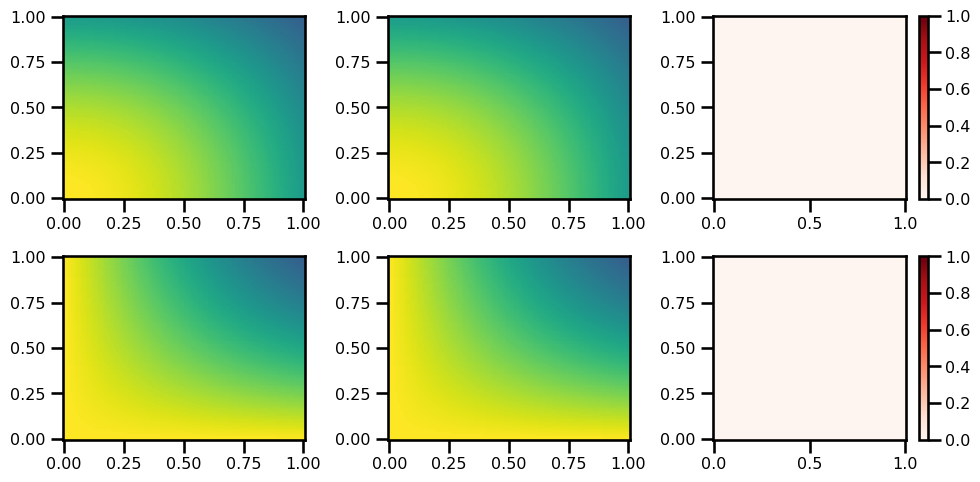

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

ax[0, 0].pcolormesh(X, Y, dFdX_func_api, vmin=0.0, vmax=1.0)
ax[0, 1].pcolormesh(X, Y, dFdX_analytical, vmin=0.0, vmax=1.0)
pts = ax[0, 2].pcolormesh(
    X, Y, np.abs(dFdX_func_api - dFdX_analytical), cmap="Reds", vmin=0.0, vmax=1.0
)
plt.colorbar(pts)

ax[1, 0].pcolormesh(X, Y, dFdY_func_api, vmin=-1.0, vmax=0.0)
ax[1, 1].pcolormesh(X, Y, dFdY_analytical, vmin=-1.0, vmax=0.0)
pts = ax[1, 2].pcolormesh(
    X, Y, np.abs(dFdY_func_api - dFdY_analytical), cmap="Reds", vmin=0.0, vmax=1.0
)


plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Operator API

In [9]:
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from jaxsw._src.operators.fd import Difference

# define domain
domain = Domain(xmin=(x.min(), y.min()), xmax=(x.max(), y.max()), dx=(dx, dy))
# initialize values
F = jnp.sin(domain.grid[..., 0]) * jnp.cos(domain.grid[..., 1])

u = Field(values=F, domain=domain)

In [10]:
# create operators
DF_DX = Difference(axis=0)
DF_DY = Difference(axis=1)

du_dx = DF_DX(u)
du_dy = DF_DY(u)

# create them on the fly
du_dx = Difference()(u, axis=0)
du_dy = Difference()(u, axis=1)

# create them on the fly (modified)
du_dx = Difference(axis=0)(u, axis=0)
du_dy = Difference(axis=0)(u, axis=1)

In [11]:
np.testing.assert_array_almost_equal(du_dx.values, dFdX_func_api)
np.testing.assert_array_almost_equal(du_dy.values, dFdY_func_api)

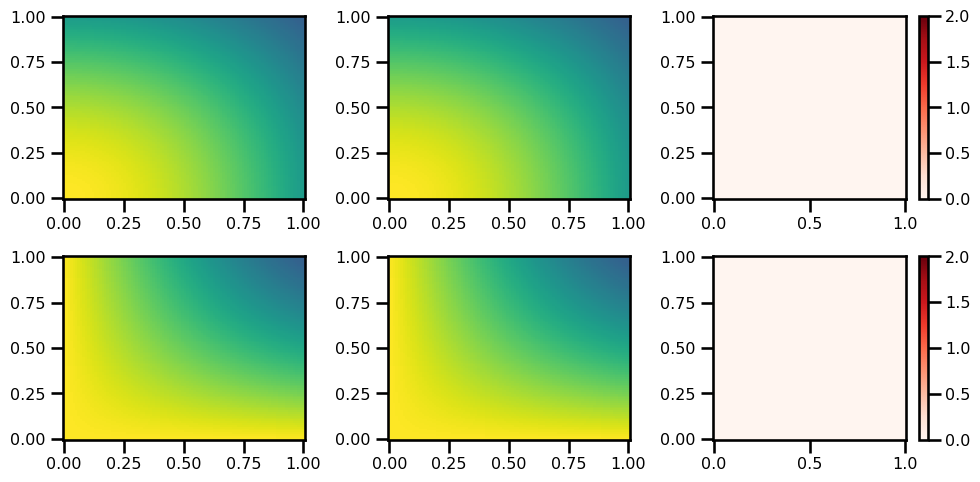

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

ax[0, 0].pcolormesh(X, Y, dFdX_func_api, vmin=0.0, vmax=1.0)
ax[0, 1].pcolormesh(X, Y, dFdX_analytical, vmin=0.0, vmax=1.0)
pts = ax[0, 2].pcolormesh(
    X, Y, np.abs(du_dx.values - dFdX_func_api), cmap="Reds", vmin=0.0, vmax=2.0
)
plt.colorbar(pts)

ax[1, 0].pcolormesh(X, Y, dFdY_func_api, vmin=-1.0, vmax=0.0)
ax[1, 1].pcolormesh(X, Y, dFdY_analytical, vmin=-1.0, vmax=0.0)
pts = ax[1, 2].pcolormesh(
    X, Y, np.abs(du_dy.values - dFdY_func_api), cmap="Reds", vmin=0.0, vmax=2.0
)


plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Velocities

In [23]:
x, y = [jnp.linspace(-1, 1, 50)] * 2
dx, dy = [x[1] - x[0]] * 2

X, Y = jnp.meshgrid(x, y, indexing="ij")

U = X**2 + Y**3  # -Y
V = X**4 + Y**3  # +X

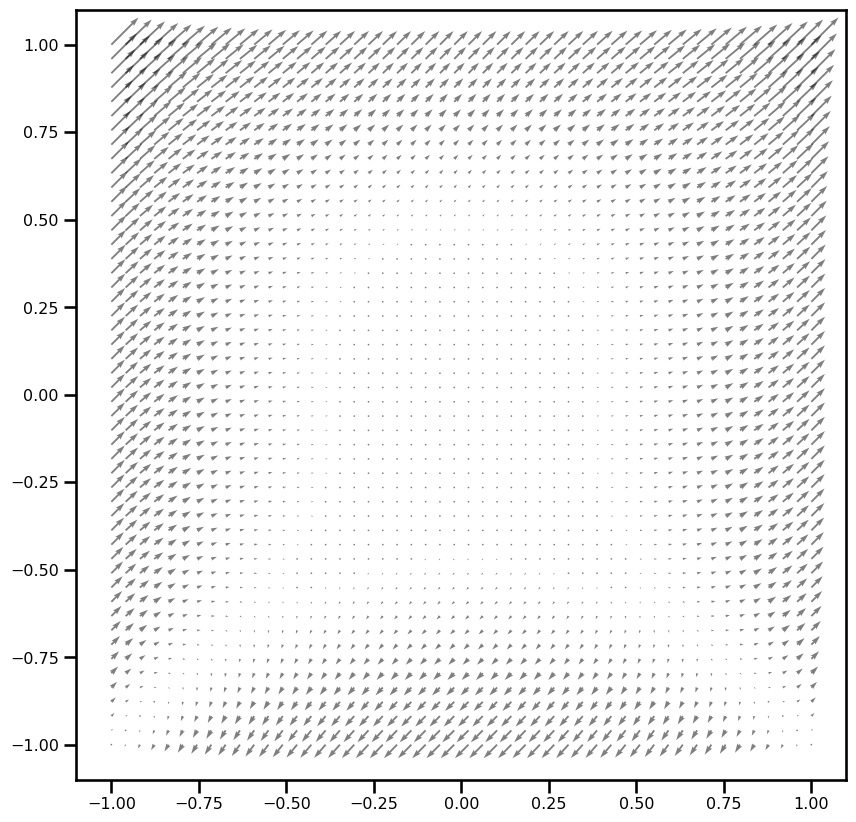

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.quiver(X, Y, U, V, color="k", alpha=0.5)

ax.set_aspect("equal", "box")
plt.show()

### Analytical

In [25]:
dUdX_analytical = 2 * X
dVdY_analytical = 3 * Y**2

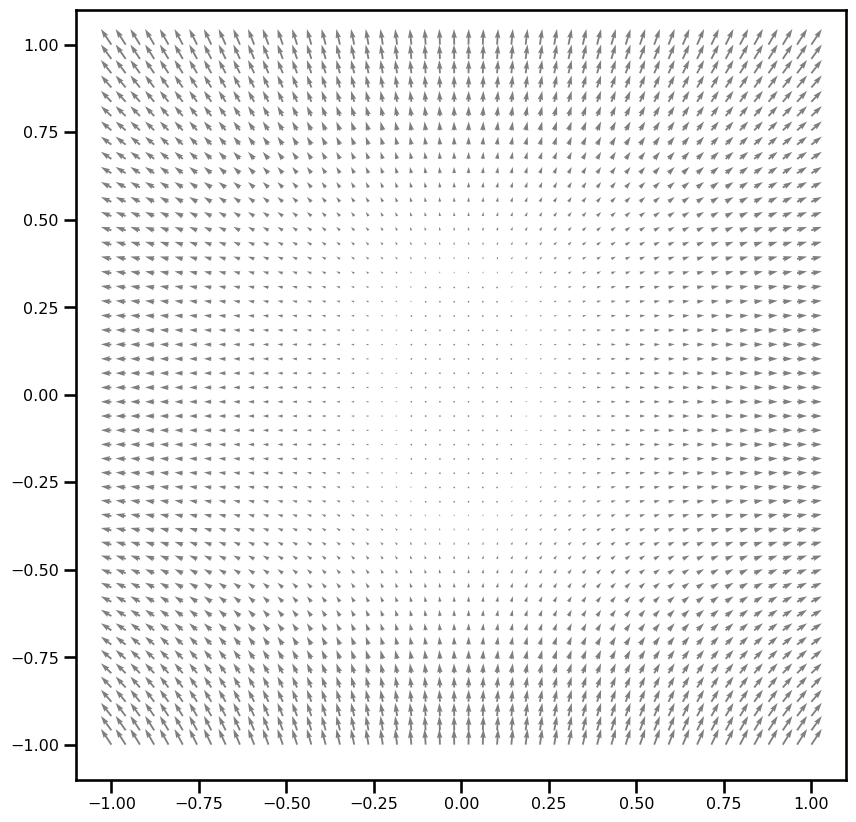

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.quiver(X, Y, dUdX_analytical, dVdY_analytical, color="k", alpha=0.5)

ax.set_aspect("equal", "box")
plt.show()

### Functional API

In [27]:
accuracy = 1
derivative = 1
method = "central"
dUdX_func_api = fdx.difference(
    array=U, axis=0, step_size=dx, accuracy=accuracy, derivative=1, method=method
)
dVdY_func_api = fdx.difference(
    array=V, axis=1, step_size=dy, accuracy=accuracy, derivative=1, method=method
)

print(f"U: {U.shape}")
print(f"V: {V.shape}")
print(f"dUdX: {dUdX_func_api.shape}")
print(f"dVdY: {dVdY_func_api.shape}")

U: (50, 50)
V: (50, 50)
dUdX: (50, 50)
dVdY: (50, 50)


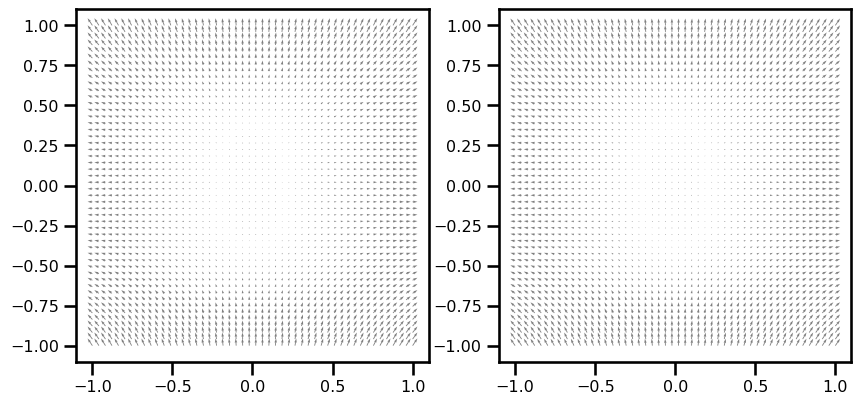

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

ax[0].quiver(X, Y, dUdX_analytical, dVdY_analytical, color="k", alpha=0.5)
ax[1].quiver(X, Y, dUdX_func_api, dVdY_func_api, color="k", alpha=0.5)
ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")
plt.show()

### Operator API

In [29]:
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from jaxsw._src.operators.fd import Difference

# define domain
domain = Domain(xmin=(x.min(), y.min()), xmax=(x.max(), y.max()), dx=(dx, dy))
# initialize values
U = domain.grid[..., 0] ** 2 + domain.grid[..., 1] ** 3  # -Y
V = domain.grid[..., 0] ** 4 + domain.grid[..., 1] ** 3  # +X

u = Field(values=U, domain=domain)
v = Field(values=V, domain=domain)

In [30]:
# create operators
DU_DX = Difference(axis=0)
DV_DY = Difference(axis=1)

du_dx = DF_DX(u)
dv_dy = DF_DY(v)

# create them on the fly
du_dx = Difference()(u, axis=0)
dv_dy = Difference()(v, axis=1)

# create them on the fly (modified)
du_dx = Difference(axis=0)(u, axis=0)
dv_dy = Difference(axis=0)(v, axis=1)

In [31]:
np.testing.assert_array_almost_equal(du_dx.values, dUdX_func_api)
np.testing.assert_array_almost_equal(dv_dy.values, dVdY_func_api)

AssertionError: 
Arrays are not almost equal to 6 decimals

(shapes (51, 51), (50, 50) mismatch)
 x: array([[-1.959184, -1.959184, -1.959184, ..., -1.959184, -1.959184,
        -1.959187],
       [-1.918368, -1.918368, -1.918368, ..., -1.918367, -1.918368,...
 y: array([[-1.959184, -1.959184, -1.959184, ..., -1.959181, -1.959184,
        -1.959184],
       [-1.918368, -1.918368, -1.918368, ..., -1.918367, -1.918367,...

In [68]:
x, y = [jnp.linspace(-1, 1, 50)] * 2
dx, dy = [x[1] - x[0]] * 2

X, Y = jnp.meshgrid(x, y, indexing="ij")

U = X**2 + Y**3  # -Y
V = X**4 + Y**3  # +X
F = jnp.stack([F1, F2], axis=0)
dF1dX_analytical = 2 * X
dF2dY_analytical = 3 * Y**2
gradF_analytical = jnp.stack([dF1dX, dF2dY], axis=0)

In [69]:
from jaxsw._src.operators.functional.fd import difference, gradient


step_size = dx
accuracy = 4
method = "central"
mode = "edge"
dF1dX = difference(
    array=F1, axis=0, step_size=step_size, accuracy=accuracy, method=method
)
dF2dY = difference(
    array=F2, axis=1, step_size=step_size, accuracy=accuracy, method=method
)

print(f"F: {F.shape}")
print(f"dFdX: {dF1dX.shape}")
print(f"dFdY: {dF2dY.shape}")

F: (2, 50, 50)
dFdX: (50, 50)
dFdY: (50, 50)


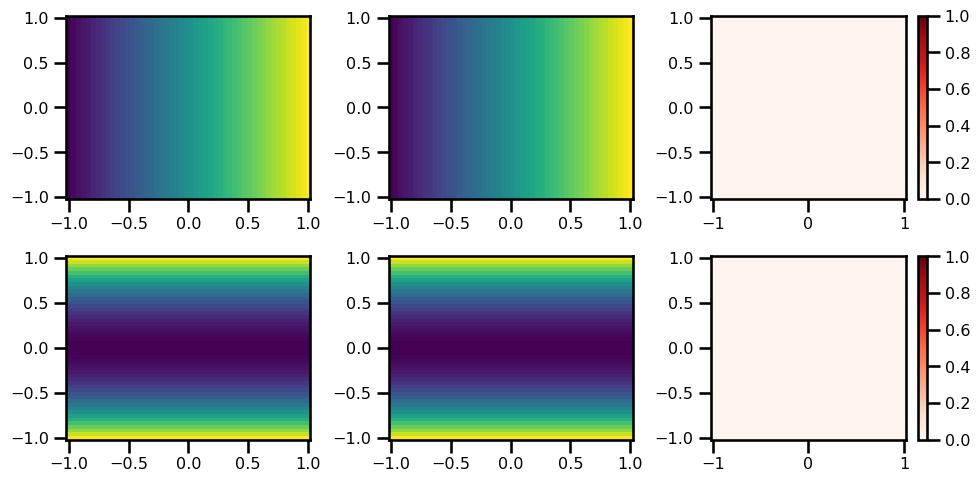

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

ax[0, 0].pcolormesh(X, Y, dF1dX)
ax[0, 1].pcolormesh(X, Y, dF1dX_analytical)
pts = ax[0, 2].pcolormesh(
    X, Y, np.abs(dF1dX - dF1dX_analytical), cmap="Reds", vmin=0.0, vmax=1.0
)
plt.colorbar(pts)

ax[1, 0].pcolormesh(X, Y, dF2dY)
ax[1, 1].pcolormesh(X, Y, dF2dY_analytical)
pts = ax[1, 2].pcolormesh(
    X, Y, np.abs(dF2dY - dF2dY_analytical), cmap="Reds", vmin=0.0, vmax=1.0
)


plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [ ]:
x, y = [jnp.linspace(-1, 1, 50)] * 2
dx, dy = [x[1] - x[0]] * 2

X, Y = jnp.meshgrid(x, y, indexing="ij")

F1 = X**2 + Y**3  # -Y
F2 = X**4 + Y**3  # +X
F = jnp.stack([F1, F2], axis=0)
dF1dX_analytical = 2 * X
dF2dY_analytical = 3 * Y**2
gradF_analytical = jnp.stack([dF1dX, dF2dY], axis=0)

In [76]:
F.shape, F1.shape

((2, 50, 50), (50, 50))

In [75]:
from jaxsw._src.operators.functional.fd import difference, gradient


step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
gradF = gradient(array=F1, step_size=step_size, accuracy=accuracy, method=method)

print(f"F: {F.shape}")
print(f"dFdX: {gradF.shape}")

F: (2, 50, 50)
dFdX: (2, 50, 50)


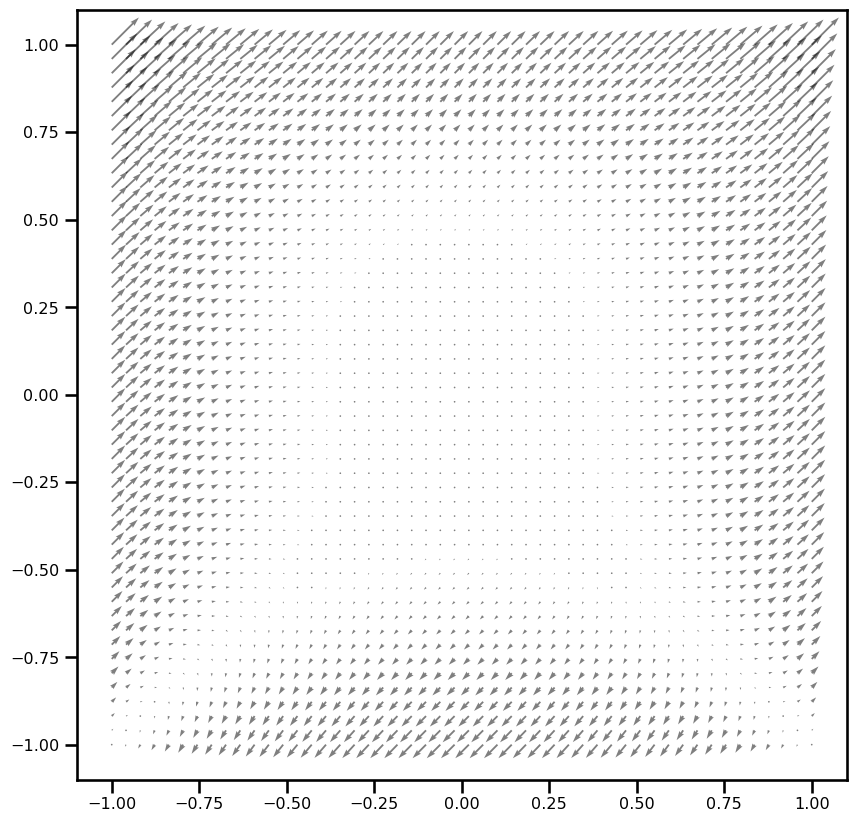

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.quiver(X, Y, F1, F2, color="k", alpha=0.5)

ax.set_aspect("equal", "box")
plt.show()

In [78]:
from jaxsw._src.operators.functional.fd import difference, gradient, jacobian


step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
JacobianF = jacobian(array=F, step_size=step_size, accuracy=accuracy, method=method)

print(f"F: {F.shape}")
print(f"Jacobian F: {JacobianF.shape}")

F: (2, 50, 50)
Jacobian F: (2, 2, 50, 50)


In [84]:
from jaxsw._src.operators.functional.fd import (
    difference,
    divergence,
    gradient,
    jacobian,
)


step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
divF = divergence(
    array=F,
    step_size=step_size,
    accuracy=accuracy,
    method=method,
    keepdims=False,
)

print(f"F: {F.shape}")
print(f"Div F: {divF.shape}")

F: (2, 50, 50)
Div F: (50, 50)


In [87]:
from jaxsw._src.operators.functional.fd import (
    difference,
    divergence,
    gradient,
    jacobian,
    laplacian,
)


step_size = (dx, dy)
accuracy = 4
method = "central"
mode = "edge"
lapF = laplacian(array=F1, step_size=step_size, accuracy=accuracy, method=method)

print(f"F: {F.shape}")
print(f"Laplacian F: {lapF.shape}")

F: (2, 50, 50)
Laplacian F: (50, 50)
